In [1]:
from dataset_creation import TextDataset
from torch.utils.data import DataLoader
import numpy as np
import torch

# Instantiate the dataset
text_dataset = TextDataset(directory='data/SPGC-tokens-2018-07-18/', sequence_length=100)
print(f"Dataset created with {len(text_dataset)} sequences.")

# Define chars using keys of char_to_idx
chars = list(text_dataset.char_to_idx.keys())

n_characters = text_dataset.n_characters  # Number of unique characters
print(f"Number of unique characters: {n_characters}")
print(f"Characters: {chars}")

Dataset created with 18422222637 sequences.
Number of unique characters: 70
Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ',', '.', ';', "'", '"', '?', '!', ' ']


In [2]:
from hebbian_model import HebbianLinear, SimpleRNN, clip_weights
# Import the functions for saving model data
from vis import register_hooks, save_model_data

input_size = n_characters
output_size = n_characters
n_hidden = 128
rnn = SimpleRNN(input_size, n_hidden, output_size, 3)

# Zero Initialization
for p in rnn.parameters():
    torch.nn.init.zeros_(p)

# Orthogonal Initialization (particularly good for RNNs)
# for p in rnn.parameters():
#     if p.dim() > 1:
#         nn.init.orthogonal_(p)

# Register hooks to capture activations
activations = register_hooks(rnn)

# Initialize a counter for training instances
training_instance = 0

# Define the loss function (criterion)
criterion = torch.nn.NLLLoss()

In [3]:
def randomTrainingExample():
    """Generate a random training example from the dataset"""
    sequence, line_tensor = text_dataset[np.random.randint(len(text_dataset))]
    return sequence, line_tensor

randomTrainingExample()

('hare hence the ant is not only in connection with the locust but also with the grasshopper the hindo',
 tensor([ 7,  0, 17,  4, 69,  7,  4, 13,  2,  4, 69, 19,  7,  4, 69,  0, 13, 19,
         69,  8, 18, 69, 13, 14, 19, 69, 14, 13, 11, 24, 69,  8, 13, 69,  2, 14,
         13, 13,  4,  2, 19,  8, 14, 13, 69, 22,  8, 19,  7, 69, 19,  7,  4, 69,
         11, 14,  2, 20, 18, 19, 69,  1, 20, 19, 69,  0, 11, 18, 14, 69, 22,  8,
         19,  7, 69, 19,  7,  4, 69,  6, 17,  0, 18, 18,  7, 14, 15, 15,  4, 17,
         69, 19,  7,  4, 69,  7,  8, 13,  3, 14]))

In [4]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
imprint_rate = 0.00
last_n_rewards = [0]
last_n_reward_avg = 0
n_rewards = 100
stochasticity = 0.001
save_frequency = 100000  # Save data every 10k characters
rnn.train()
def train(line_tensor, l2_lambda=0.001):
    global training_instance, last_n_rewards, last_n_reward_avg
    hidden = rnn.initHidden()  # Initialize the hidden state of the RNN

    losses = []  # To store losses for each step in the sequence
    l2_reg = None  # For accumulating the L2 regularization term
    output = None  # To store the output of the RNN

    for i in range(line_tensor.size()[0] - 1):
        l2_reg = None  # Reset L2 regularization term for each character
        # Convert the current character to a one-hot encoded tensor
        hot_input_char_tensor = torch.nn.functional.one_hot(line_tensor[i], num_classes=n_characters).type(torch.float).unsqueeze(0)

        with torch.no_grad():  # Disable gradient calculations
            # Forward pass through the RNN
            output, hidden = rnn(hot_input_char_tensor, hidden)

            # Compute the loss for this step
            loss = criterion(output, line_tensor[-1].unsqueeze(0))

            # Compute the L2 regularization term
            for param in rnn.parameters():
                if l2_reg is None:
                    l2_reg = param.norm(2)  # L2 norm of the parameter
                else:
                    l2_reg = l2_reg + param.norm(2)
            loss = loss + l2_lambda * l2_reg  # Add the L2 regularization term to the loss

            # Convert loss to a reward signal for Hebbian updates
            reward = -loss.item()
            last_n_rewards.append(reward)
            if len(last_n_rewards) > n_rewards:
                last_n_rewards.pop(0)
            last_n_reward_avg = sum(last_n_rewards) / len(last_n_rewards)
            reward_update = reward - last_n_reward_avg

            # Clip the weights to prevent them from exploding
            # clip_weights(rnn, max_norm=0.5)

            # Apply Hebbian updates to the network
            rnn.apply_imprints(reward_update, learning_rate, imprint_rate)

            # normalize the weights to prevent them from exploding
            for p in rnn.parameters():
                p.data = p.data / (p.data.norm(2) + 1e-6)

            # Apply stochastic noise to the weights
            for p in rnn.parameters():
                noise = stochasticity * torch.randn_like(p.data)
                p.data += noise

        losses.append(loss.item())  # Store the loss for this step
        if (training_instance % save_frequency == 0):
            # Save the model and activations periodically
            save_model_data(rnn, activations, training_instance)
        training_instance += 1

    # Calculate the average loss for the sequence
    loss_avg = sum(losses) / len(losses)
    return output, loss_avg

# Example usage
# l2_lambda = 0.001  # Set the L2 regularization strength
# output, avg_loss = train(line_tensor, l2_lambda=l2_lambda)  # Train the model



In [5]:
import wandb
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="hebby",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "architecture": "crazy hebbian thing",
    "dataset": "wikidump",
    "epochs": 1,
    "stochasticity": stochasticity,
    "imprint_rate": imprint_rate,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: jaden-lorenc (jadens_team). Use `wandb login --relogin` to force relogin


In [6]:
import time
import math

n_iters = 10000
print_every = 50
plot_every = 20

# Keep track of losses for plotting
current_loss = 0
all_losses = []

# columns = ["correct", "predicted_char", "target_char", "sequence"]
# table = wandb.Table(columns=columns)

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    sequence, line_tensor = randomTrainingExample()
    output, loss = train(line_tensor)
    current_loss += loss
    # Check if loss is NaN
    if math.isnan(loss):
        print("Loss is NaN, breaking...")
        parameters = list(rnn.parameters())
        for p in parameters:
            print(p.data)
        break
    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        # Use the output to generate a character prediction
        topv, topi = output.topk(1, dim=1)  # Change dim to 1
        predicted_char = text_dataset.idx_to_char[topi[0, 0].item()]
        target_char = sequence[-1]
        correct = '✓' if predicted_char == target_char else '✗ (%s)' % target_char
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, sequence, predicted_char, correct))
        wandb.log({"correct": correct, "predicted_char": predicted_char, "target_char": target_char, "sequence": sequence})
        # row = [correct, predicted_char, target_char, ''.join(sequence)]
        # table.add_data(*row)
        # wandb.log({"predictions": table}, commit=False)

        # also print some weights:
        # print("i2h weights:", rnn.i2h.weight)
        # print("i2o weights:", rnn.i2o.weight)

    # Add current loss avg to list of losses source /home/deck/miniconda3/bin/activate /home/deck/Documents/memory_encoding/hebby
    if iter % plot_every == 0:
        wandb.log({"loss": current_loss / plot_every})
        all_losses.append(current_loss / plot_every)
        current_loss = 0

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

Visualizing all layers and saving to model_data/visualization_0.png
100 1% (0m 20s) 4.3047  eyes numb with terror she rose in the bed and slipped her hand under pillow the wallet was quite cl / q ✗ (l)
200 2% (0m 39s) 4.2486 raight but somewhat low the nose generally long and straight but sometimes slightly aquiline the lip / 6 ✗ (p)
300 3% (0m 57s) 4.3655  forbid thee shall the duke instantly know and of that letter too this seems a fair deserving and mu / y ✗ (u)
400 4% (1m 15s) 4.2402 umb less defn without a thumb darwin thumbscrew thumb a screw having a or knurled head so that it ma / H ✗ (a)
500 5% (1m 33s) 4.3916 ng figure or rather pair of figures when with a sudden start he found sheila s sad and earnest eyes  / H ✗ ( )
600 6% (1m 51s) 4.3737 i as it might have been foreseen it was in italy that cecilia s maiden dreams of life had opened she / o ✗ (e)
700 7% (2m 9s) 4.3739  praised it highly thus it was not improbable that the generous man would if philip besought him int / a ✗

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


loss,▆▅▇▄▄▅▆█▄█▇▆▄▇▆▄▅▄▆▅▆▄▃▃▅▅▄▄▄▆▅▄▆▃▅▁▆▆▄▂
correct,✗ (h)
loss,4.26578
predicted_char,s
sequence,als may apply for an...
target_char,h


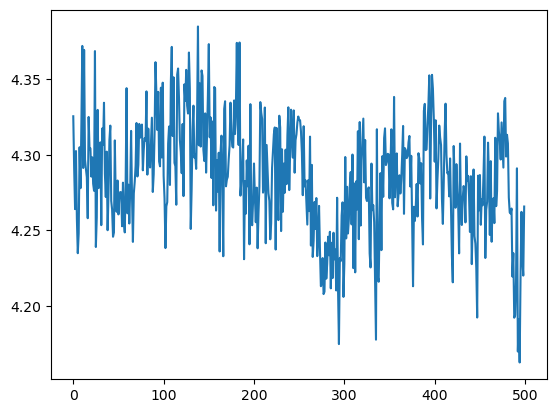

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

torch.Size([1, 128])


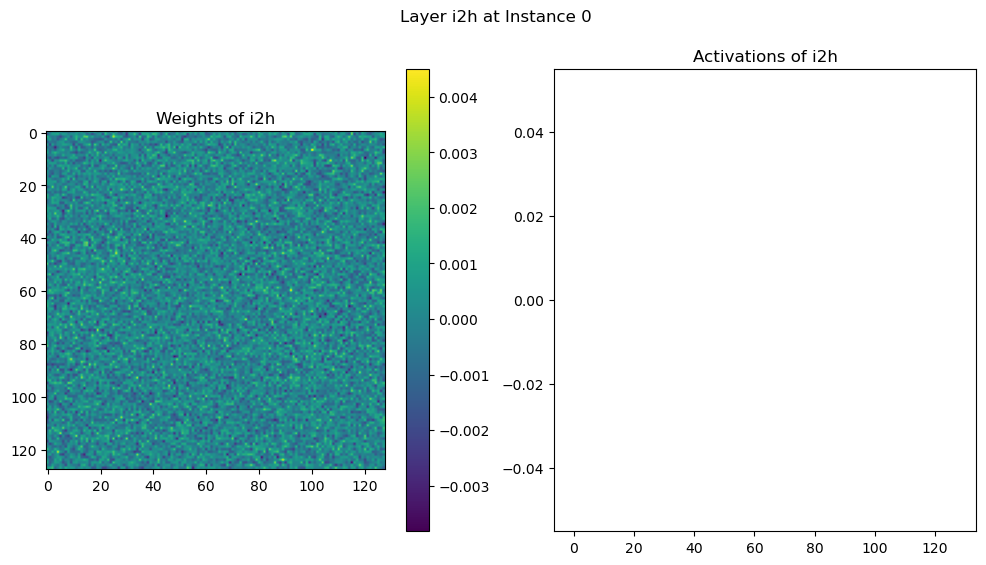

In [8]:
from vis import visualize_model_data
# Now visualize the data for a specific layer and instance
# Replace 'layer_name' with the actual name of the layer you want to visualize
visualize_model_data('i2h', 0)


In [9]:
from vis import visualize_all_layers_and_save

visualize_all_layers_and_save(rnn, 0, "jusone.png")

Visualizing all layers and saving to jusone.png


In [10]:
from vis import create_animation_from_visualizations

# create_animation_from_visualizations(rnn, 'model_data', 'model_evolution.gif', format='gif')

In [11]:
create_animation_from_visualizations(rnn, 'model_data', 'model_evolution.mp4', format='mp4')

Visualizing all layers and saving to model_data/visualization_0.png
Visualizing all layers and saving to model_data/visualization_100000.png
Visualizing all layers and saving to model_data/visualization_200000.png
Visualizing all layers and saving to model_data/visualization_300000.png
Visualizing all layers and saving to model_data/visualization_400000.png
Visualizing all layers and saving to model_data/visualization_500000.png
Visualizing all layers and saving to model_data/visualization_600000.png
Visualizing all layers and saving to model_data/visualization_700000.png
Visualizing all layers and saving to model_data/visualization_800000.png
Visualizing all layers and saving to model_data/visualization_900000.png


[rawvideo @ 0x709f540] Stream #0: not enough frames to estimate rate; consider increasing probesize
